In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bayesian Multilevel Modelling 

Modelling game outcome as one of three classes: win, lose, draw 

The covariates in this dataset consists of: teams, date, and venue (home or neutral)

Since teams are a highly cardinal categorical variable, it is hard to use standard linear regression models as one hot encoding will result in the curse of dimensionality. Therefore, we use Bayesian Hierarchical modelling to allow for exchangability between the team specific coefficients. This allows for 'borrowing of strength' i.e. teams with more data and higher precision will be able to inform of teams with less. 

This also allows us to form priors, for which we can choose non informative ones.

In [30]:
results = pd.read_csv('/kaggle/input/international-football-results-from-1872-to-2017/results.csv')
results.head()
results['game'] = results['date']+ '-'+results['home_team']+ '-'+results['away_team']

**Reformat such that each row is with respect to a team**, and has a variable for the opponent. Therefore every game has 2 rows.

In [31]:
away_df = results[['game','away_team', 'home_team', 'date', 'away_score', 'home_score', 'tournament',
                  'city', 'country', 'neutral']]
## RENAME BEFORE ORDERING -- OR ELSE PD.CONCAT WILL MATCH THE COL NAMES EVEN IF THEYRE NOT IN THE SAME ORDER
away_df.columns = ['game', 'team', 'opponent','date', 'goals_scored', 'goals_conceded', 'tournament', 'city', 'country', 'neutral']
home_df = results[['game','home_team', 'away_team', 'date', 'home_score', 'away_score', 'tournament',
                  'city', 'country', 'neutral']]
## repeat 
home_df.columns = ['game', 'team', 'opponent','date', 'goals_scored', 'goals_conceded', 'tournament', 'city', 'country', 'neutral']
results_reshaped = pd.concat([home_df, away_df], axis = 0)
## change the column names to reflect the new data perspective
## add team outcome -- use if else function to get win or draw or lose comparing goals scored and conceded
results_reshaped['game_outcome'] = results_reshaped.apply(lambda row: 'win' if row['goals_scored'] > row['goals_conceded'] else ('lose' if row['goals_scored'] < row['goals_conceded'] else 'draw'), axis=1)
## clean date 
results_reshaped['date'] = pd.to_datetime(results_reshaped['date'], format = '%Y-%m-%d')

results_reshaped = results_reshaped.sort_values('date')
results_reshaped.shape

(94762, 11)

In [32]:
## Apply ordering to the win/draw/lose outcome variable 
results_reshaped.game_outcome = pd.Categorical(results_reshaped.game_outcome, 
                      categories=["lose","draw","win"],
                      ordered=True)

In [33]:
results_reshaped.head(4)

,game,team,opponent,date,goals_scored,goals_conceded,tournament,city,country,neutral,game_outcome
0,1872-11-30-Scotland-England,Scotland,England,1872-11-30,0.0,0.0,Friendly,Glasgow,Scotland,False,draw
0,1872-11-30-Scotland-England,England,Scotland,1872-11-30,0.0,0.0,Friendly,Glasgow,Scotland,False,draw
1,1873-03-08-England-Scotland,England,Scotland,1873-03-08,4.0,2.0,Friendly,London,England,False,win
1,1873-03-08-England-Scotland,Scotland,England,1873-03-08,2.0,4.0,Friendly,London,England,False,lose


In [34]:
## Ensure that all games have two rows 
results_reshaped.groupby('game')['team'].count().value_counts()

team
2    47336
4       20
Name: count, dtype: int64

# Some visualisations

Number of teams: 336


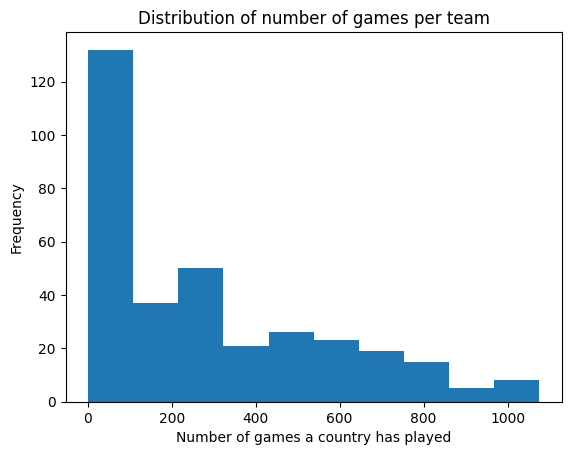

In [35]:
print(f'Number of teams: {results_reshaped.team.nunique()}')
results_reshaped.team.value_counts().plot(kind = 'hist')
plt.title('Distribution of number of games per team')
plt.xlabel('Number of games a country has played')
plt.show()

We have **327** different teams and the number of games (i.e. datapoints) we have for each team varies a lot, and resembles an exponential type distribution that is right skewed.

This means that the estimation for some team (e.g. team coefficient) will be precise but not for others that have fewer observations, if we were to use a standard fixed effects model.

## Reducing the sample space -- big tournaments

We can reduce the number of teams by focusing on 'bigger teams' i.e. filter for teams that are in the top 5 tournaments

In [36]:
print(results_reshaped.tournament.value_counts().drop('Friendly').head(5))
top_5_tournments = results_reshaped.tournament.value_counts().drop('Friendly').head(5).index
binary_mask_countries = results_reshaped.tournament.isin(top_5_tournments)
set_of_countries = set(results_reshaped.team[binary_mask_countries])
print(f'New number of countries : {len(set_of_countries)}')

tournament
FIFA World Cup qualification            16338
UEFA Euro qualification                  5648
African Cup of Nations qualification     4248
FIFA World Cup                           1928
Copa América                             1746
Name: count, dtype: int64
New number of countries : 218


In [37]:
results_reshaped_reduced = results_reshaped[results_reshaped.team.isin(set_of_countries)]
print(f'Original number of rows: {len(results_reshaped)}')
print(f'After reducing, number of rows: {len(results_reshaped_reduced)}')

Original number of rows: 94762
After reducing, number of rows: 91235


## Reducing the sample space -- dates

We can get observations for the past 50 years

In [38]:
date_range = (results_reshaped_reduced.date.min().strftime('%d - %b - %Y'),results_reshaped_reduced.date.max().strftime('%d - %b - %Y'))
print(f'Current date range: {date_range}')

Current date range: ('30 - Nov - 1872', '14 - Jul - 2024')


In [39]:
date_threshold =  results_reshaped_reduced.date.max() - pd.DateOffset(years=50)
print(date_threshold)
results_reshaped_further_reduced = results_reshaped_reduced[results_reshaped_reduced.date > date_threshold]
print(f'Original number of rows: {len(results_reshaped_reduced)}')
print(f'After reducing, number of rows: {len(results_reshaped_further_reduced)}')

1974-07-14 00:00:00
Original number of rows: 91235
After reducing, number of rows: 72329


### Countries with highest win rates

We find this by finding the $\hat{p} = \text{prob(Win)}$, and we can similarly find the variance of this estimator via the variance for binomial distribution: 

$Var(\hat{p}) = \frac{\hat{p}(1-\hat{p})}{n}$

In [40]:
wld_table = results_reshaped_further_reduced.groupby('team')['game_outcome'].value_counts(normalize = True).unstack()
wld_table['number of games'] = results_reshaped_further_reduced.groupby('team')['game_outcome'].count()

#### Top winning teams with at least 100 games

In [41]:
top_10_teams = wld_table[wld_table['number of games'] > 100].sort_values('win', ascending = False).head(10).round(2)
top_10_teams['win prob std dev'] = np.sqrt(top_10_teams['win']*(1-top_10_teams['win'])/top_10_teams['number of games'])

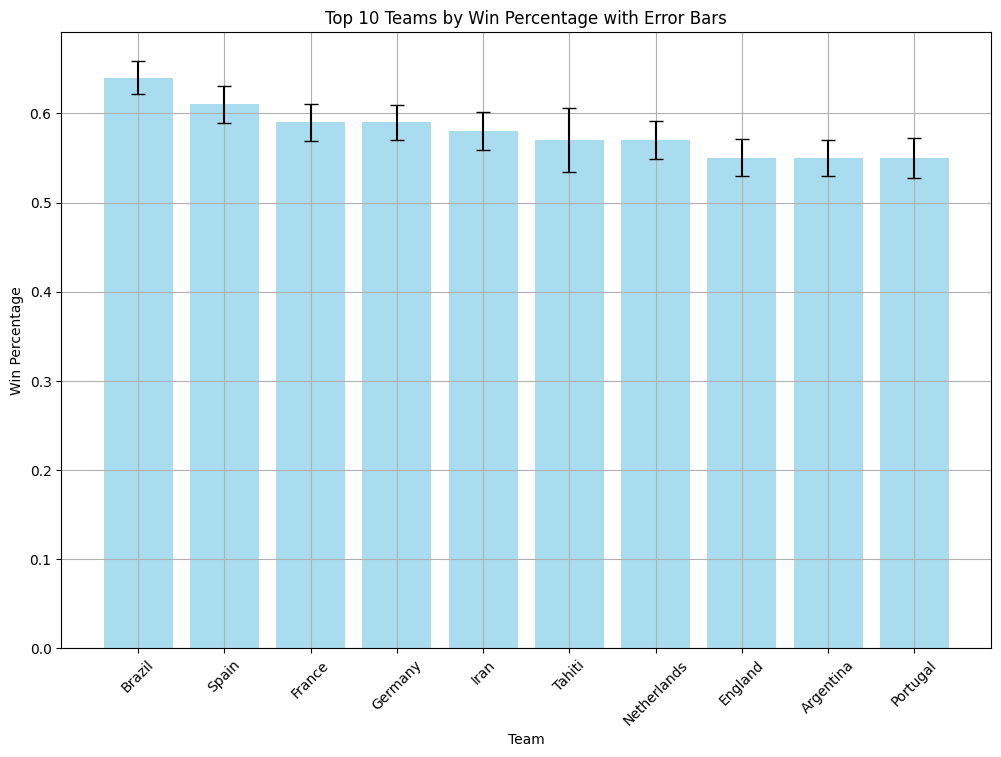

In [42]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_10_teams.index, top_10_teams['win'], yerr=top_10_teams['win prob std dev'], capsize=5, color='skyblue', alpha=0.7)
plt.xlabel('Team')
plt.ylabel('Win Percentage')
plt.title('Top 10 Teams by Win Percentage with Error Bars')
plt.xticks(rotation=45)
plt.grid(True) ## show grids for aesthetics 
plt.show()

## Extra: what is the distribution of winning rates across all countries? Is it competitive or skewed? What about the drawing?

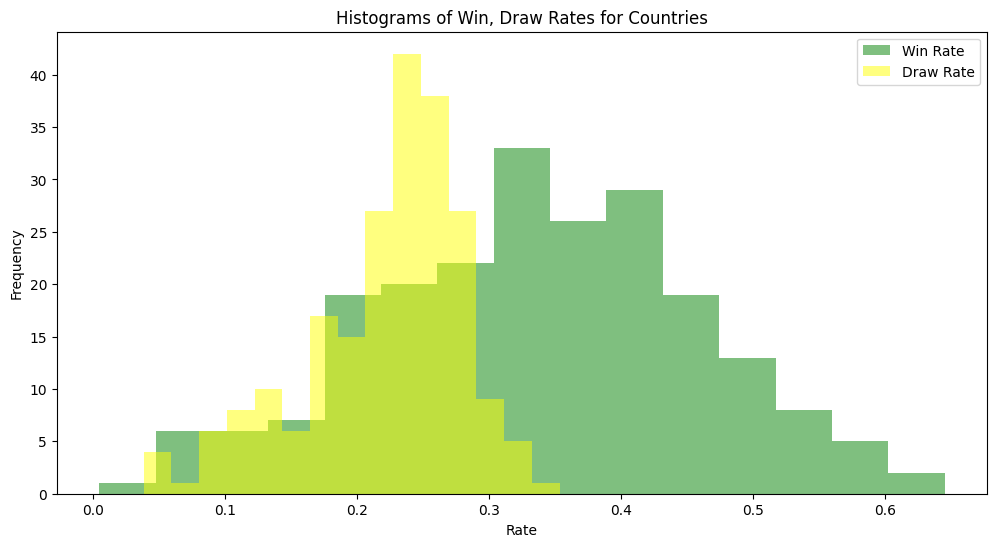

In [43]:
plt.figure(figsize=(12, 6))

# Histogram for win rates
plt.hist(wld_table['win'], bins=15, alpha=0.5, label='Win Rate', color='green')

# Histogram for draw rates
plt.hist(wld_table['draw'], bins=15, alpha=0.5, label='Draw Rate', color='yellow')

# Add labels and title
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histograms of Win, Draw Rates for Countries')
plt.legend(loc='upper right')

# Show plot
plt.show()

# Bayesian modelling 

* We use a categorical outcome model, that is an extension of the logistic regression model
* This uses a linear predictor that enters into a sigmoid function, so as to capture probability that is bounded between 0 and 1. 
* The extension of binary to multi class models means that we use a softmax function instead of the regular sigmoid.

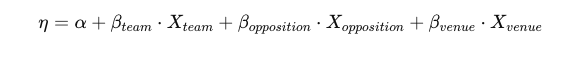




## Data prep

Let us revise the columns we have: 

In [44]:
df = results_reshaped_further_reduced
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72329 entries, 9773 to 47380
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game            72319 non-null  object        
 1   team            72319 non-null  object        
 2   opponent        72319 non-null  object        
 3   date            72329 non-null  datetime64[ns]
 4   goals_scored    72307 non-null  float64       
 5   goals_conceded  72307 non-null  float64       
 6   tournament      72329 non-null  object        
 7   city            72329 non-null  object        
 8   country         72329 non-null  object        
 9   neutral         72329 non-null  bool          
 10  game_outcome    72329 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](1), float64(2), object(6)
memory usage: 5.7+ MB


### 1. Check NAs

In [45]:
row_has_na = df.isna().sum(axis = 1) > 0
print(f'Number of rows with NAs: {row_has_na.sum()}')
df_no_na = df[~row_has_na]
print(f'Resultant df shape: {df_no_na.shape}')
print(f'Original df shape: {df.shape}')


Number of rows with NAs: 22
Resultant df shape: (72307, 11)
Original df shape: (72329, 11)


In [46]:
df_no_na.columns

Index(['game', 'team', 'opponent', 'date', 'goals_scored', 'goals_conceded',
       'tournament', 'city', 'country', 'neutral', 'game_outcome'],
      dtype='object')

### 2. Form the Venue column: Home/ Away / Neutral 

In [47]:
## test with a smaller subset 
df_no_na = df_no_na.sort_values('game')
game_sample = df_no_na.game.sample(5, random_state = 41).unique()
sample_subset = df_no_na[['game', 'team', 'opponent', 'country', 'neutral']][df_no_na.game.isin(game_sample)]
sample_subset

,game,team,opponent,country,neutral
11134,1977-10-22-Mexico-Canada,Mexico,Canada,Mexico,False
11134,1977-10-22-Mexico-Canada,Canada,Mexico,Mexico,False
15955,1988-02-11-Yemen-India,Yemen,India,United Arab Emirates,True
15955,1988-02-11-Yemen-India,India,Yemen,United Arab Emirates,True
19776,1994-07-07-Vanuatu-Papua New Guinea,Vanuatu,Papua New Guinea,Solomon Islands,True
19776,1994-07-07-Vanuatu-Papua New Guinea,Papua New Guinea,Vanuatu,Solomon Islands,True
25863,2001-09-01-Republic of Ireland-Netherlands,Republic of Ireland,Netherlands,Republic of Ireland,False
25863,2001-09-01-Republic of Ireland-Netherlands,Netherlands,Republic of Ireland,Republic of Ireland,False
43926,2021-06-05-Panama-Anguilla,Anguilla,Panama,Panama,False
43926,2021-06-05-Panama-Anguilla,Panama,Anguilla,Panama,False


In [48]:
print(f'Total number of rows: {df_no_na.shape[0]}')
print(f'Number of homes : {(df_no_na.team == df_no_na.country).sum()}')
print(f'Number of neutrals : {df_no_na.neutral.sum()}')
print(f'Number of aways : {((df_no_na.team != df_no_na.country)&  ~df_no_na.neutral).sum()}')


Total number of rows: 72307
Number of homes : 26299
Number of neutrals : 19174
Number of aways : 26837


In [49]:
## Form the home/away/neutral column
# df.apply(lambda row: 'home' if row['team'] == row['country'] else 'neutral' if row['neutral'] else 'away')
home = df_no_na.team == df_no_na.country
neutral = df_no_na.neutral
## the rest would be away,i.e. if not neutral and not home
away = np.logical_and(df_no_na.team != df_no_na.country,~df_no_na.neutral)

df_no_na['venue'] = None
df_no_na.loc[home, 'venue'] = 'home'
df_no_na.loc[neutral, 'venue'] = 'neutral'
df_no_na.loc[away, 'venue'] = 'away'

In [50]:
## Check 
df_no_na.venue.value_counts()

venue
away       26837
home       26296
neutral    19174
Name: count, dtype: int64

Home and away are imbalanced -- remove observations that are causing this

In [51]:
## filter out neutrals 
df_no_neutral = df_no_na[~df_no_na['neutral']]
print(df_no_neutral.shape)

## count home and away for these
balanced_home_away = df_no_neutral.groupby('game')['venue'].value_counts().unstack().fillna(0).sum(axis = 1) == 2
balanced_games = df_no_neutral.groupby('game').count().index[balanced_home_away]
print(f'Number of balanced games : {len(balanced_games)}')

(53133, 12)
Number of balanced games : 26282


In [52]:
## subset for balanced games
to_subset = df_no_na['game'].isin(balanced_games)
to_subset.sum()
df_no_na_balanced = df_no_na[to_subset]
print(df_no_na_balanced.shape)
print(df_no_na.shape)

(52564, 12)
(72307, 12)


# Begin Bayesian 

In [57]:
# conda install theano
# %conda install pymc
# %conda install scipy
%pip install pymc scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.7.0
    Uninstalling rich-13.7.0:
      Successfully uninstalled rich-13.7.0
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.13.1
    Uninstalling pytensor-2.13.1:
      Successfully uninstalled pytensor-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [58]:
import pymc as pm

import arviz as az
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

ImportError: cannot import name 'gaussian' from 'scipy.signal' (/opt/conda/lib/python3.10/site-packages/scipy/signal/__init__.py)

In [ ]:
# Encode the outcome column to numerical values
outcome_mapping = {'L': 0, 'D': 1, 'W': 2}
df['outcome'] = df['outcome'].map(outcome_mapping)

# Encode categorical features
le_team = LabelEncoder()
le_opposition = LabelEncoder()
df['team_encoded'] = le_team.fit_transform(df['team'])
df['opposition_encoded'] = le_opposition.fit_transform(df['opposition'])

# One-hot encode the venue
df['venue'] = df.apply(lambda row: 'home' if row['team'] == row['country'] else 'neutral' if row['neutral'] else 'away', axis=1)
df = pd.get_dummies(df, columns=['venue'], drop_first=True)

# Calculate exponential decay weights
current_date = pd.to_datetime('today')
df['days_since'] = (current_date - df['date']).dt.days
df['weights'] = np.exp(-df['days_since'] / 365)  # Decay rate with half-life of 1 year

# Prepare the data
X = df[['team_encoded', 'opposition_encoded', 'venue_home', 'venue_neutral']]
y = df['outcome'].values
weights = df['weights'].values

# Normalize weights
weights /= weights.sum()